## Ambil Data

In [1]:
# Import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import random
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFilter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

# Path untuk dataset lokal di komputer Anda
base_dir = r'/content/drive/My Drive/TA/Histogram Matched'

Mounted at /content/drive


### Buat Dataframe

In [2]:
def create_dataframe(image_dir):
    # List to store image paths and their labels
    image_paths = []
    labels = []

    # Get the list of coffee roast classes
    coffee_classes = os.listdir(image_dir)

    # Iterate through each class
    for coffee_class in coffee_classes:
        class_dir = os.path.join(image_dir, coffee_class)

        # Get all image files in the class folder
        image_files = os.listdir(class_dir)

        # Add all image paths and corresponding labels to the lists
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image_paths.append(image_path)
            labels.append(coffee_class)

    # Create the dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    return df

# Create the dataframe without limiting images
df = create_dataframe(base_dir)

# Split the dataframe into train (80%), validation (10%), and test (10%) sets
train_df, test_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label'], random_state=42)

# Display the updated dataset information
print(f"Total images: {len(df)}")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")


Total images: 3600
Training set: 2880 images
Validation set: 360 images
Test set: 360 images


In [3]:
from collections import Counter

def count_images_per_class(df, set_name):
    # Count the number of images per class
    class_counts = df['label'].value_counts()

    # Display the results
    print(f"{set_name} set class distribution:")
    for label, count in class_counts.items():
        print(f"{label}: {count} images")
    print()

# Display total number of images in each dataset
print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images\n")

# Count and display images per class for each set
count_images_per_class(train_df, "Training")
count_images_per_class(val_df, "Validation")
count_images_per_class(test_df, "Test")



Train set: 2880 images
Validation set: 360 images
Test set: 360 images

Training set class distribution:
R85 (Very Light): 360 images
R35 (Dark): 360 images
R55 (Medium): 360 images
R25 (Very Dark): 360 images
R65 (Medium Light): 360 images
R45 (Moderately Dark): 360 images
R95 (Extremely Light): 360 images
R75 (Light): 360 images

Validation set class distribution:
R45 (Moderately Dark): 45 images
R55 (Medium): 45 images
R35 (Dark): 45 images
R85 (Very Light): 45 images
R25 (Very Dark): 45 images
R65 (Medium Light): 45 images
R75 (Light): 45 images
R95 (Extremely Light): 45 images

Test set class distribution:
R95 (Extremely Light): 45 images
R55 (Medium): 45 images
R65 (Medium Light): 45 images
R25 (Very Dark): 45 images
R75 (Light): 45 images
R35 (Dark): 45 images
R85 (Very Light): 45 images
R45 (Moderately Dark): 45 images



## Visualisasi Data

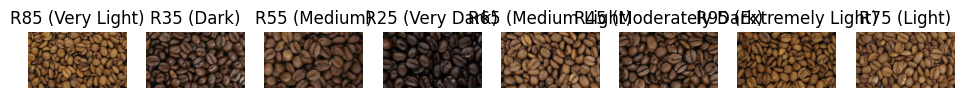

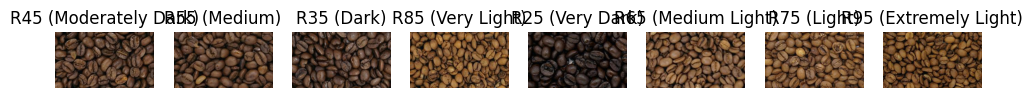

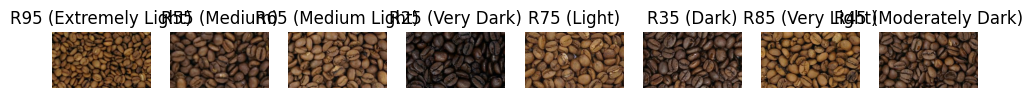

In [4]:
def show_sample_images(df, num_classes=10):
    # Ambil nama unik dari label (kelas)
    unique_classes = df['label'].unique()

    # Buat figure untuk menampilkan citra
    plt.figure(figsize=(15, 15))

    for idx, flower_class in enumerate(unique_classes[:num_classes]):
        # Ambil citra pertama dari kelas ini
        sample_image_path = df[df['label'] == flower_class]['image_path'].iloc[0]

        # Baca citra menggunakan OpenCV
        image = cv2.imread(sample_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengubah BGR ke RGB

        # Menampilkan citra
        plt.subplot(1, num_classes, idx+1)
        plt.imshow(image)
        plt.title(flower_class)
        plt.axis('off')  # Menghilangkan sumbu

    plt.show()

# Menampilkan contoh citra dari dataframe training
show_sample_images(train_df)

# Menampilkan contoh citra dari dataframe validasi
show_sample_images(val_df)

# Menampilkan contoh citra dari dataframe testing
show_sample_images(test_df)


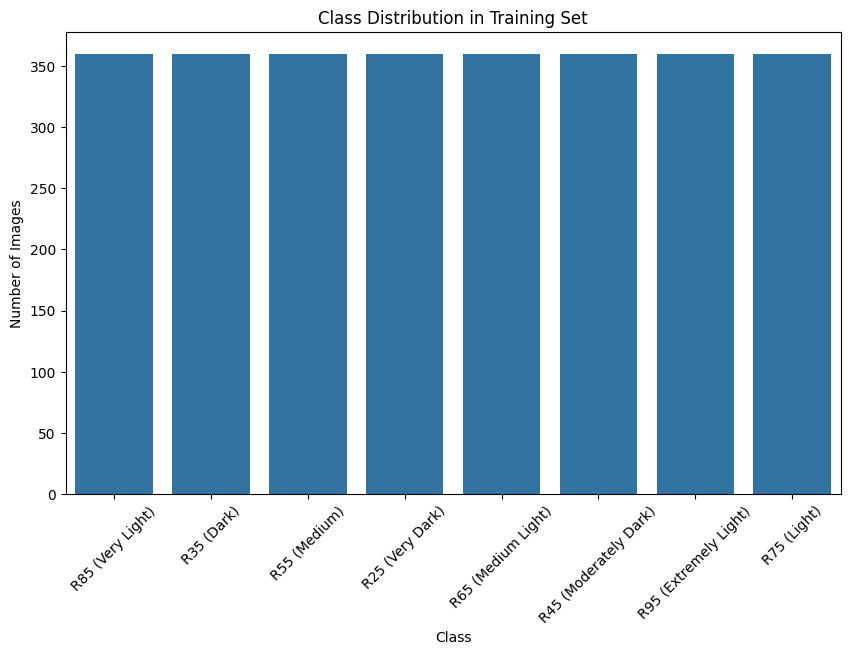

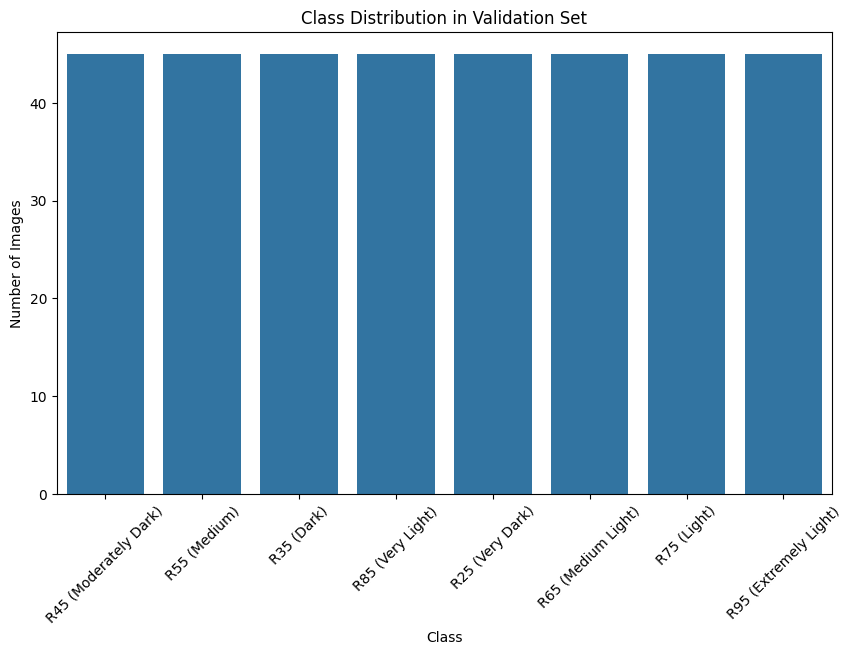

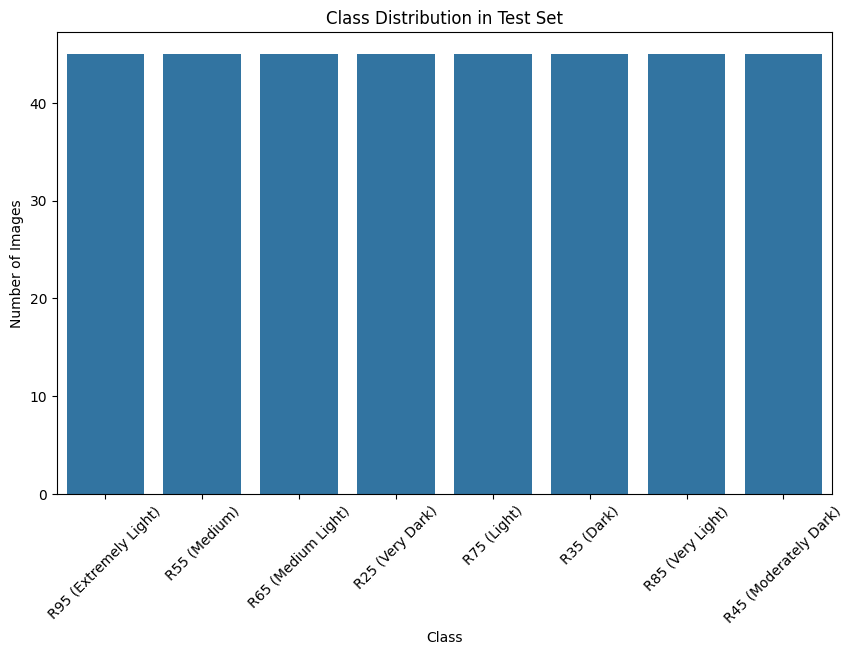

In [5]:
def visualize_class_distribution(df, title):
    # Menghitung jumlah gambar per kelas
    class_counts = df['label'].value_counts()

    # Membuat plot bar menggunakan matplotlib dan seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)

    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Visualisasi untuk train_df
visualize_class_distribution(train_df, 'Class Distribution in Training Set')

# Visualisasi untuk val_df
visualize_class_distribution(val_df, 'Class Distribution in Validation Set')

# Visualisasi untuk test_df
visualize_class_distribution(test_df, 'Class Distribution in Test Set')


## Pra-Pemrosesan

In [6]:
# Set random seeds for reproducibility
seed_value = 42  # You can choose any integer value

# Set seeds
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Fungsi-fungsi pra-pemrosesan
def reshape_images(images):
    return np.array([np.array(image).reshape(224, 224, 3) for image in images])

def enhance_image(image, factor=2.0):
    random.seed(seed_value)
    pil_image = Image.fromarray(image)
    sharpened_image = pil_image.filter(ImageFilter.SHARPEN)
    return np.array(sharpened_image)

def reduce_noise(image, ksize=5):
    random.seed(seed_value)
    # Mengurangi noise menggunakan GaussianBlur
    denoised_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return denoised_image

def increase_contrast(image, alpha=1.5, beta=0):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def one_hot_encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

In [7]:
def is_valid_file(file_name):
    return file_name.endswith(('.png', '.jpg', '.jpeg', '.JPG'))

def preprocess(df, preprocess_methods):
    processed_images = []
    labels = df['label'].tolist()  # Store labels

    for image_path in df['image_path']:
        # Check if the file is an image
        if not is_valid_file(image_path):
            print(f"Skipping non-image file: {image_path}")
            continue

        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Error: Image file does not exist at {image_path}.")
            continue

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image at {image_path}.")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Resize the image to 224x224
        image = cv2.resize(image, (224, 224))

        # Check if all preprocessing methods should be applied
        if 'all' in preprocess_methods:
            image = enhance_image(image)
            image = reduce_noise(image)
            image = increase_contrast(image)
        else:
            # Preprocess according to selected methods
            if 'enhance' in preprocess_methods:
                image = enhance_image(image)
            if 'denoise' in preprocess_methods:
                image = reduce_noise(image)
            if 'contrast' in preprocess_methods:
                image = increase_contrast(image)

        # Add the processed image to the list
        processed_images.append(image)

    return processed_images, labels


## Model

### Inisialisasi Arsitektur ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set KERAS_HOME to your desired directory
os.environ['KERAS_HOME'] = 'D:/keras_models'  # Change this to your preferred path

def create_resnet50_for_8_classes(input_shape=(224, 224, 3), num_classes=8):
    # Load ResNet50 base model with pre-trained ImageNet weights
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a custom dense layer for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with 8 classes

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Optionally, freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all base model layers

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the ResNet50 model for 8 classes
model = create_resnet50_for_8_classes(input_shape=(224, 224, 3), num_classes=8)

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# simpan weight awal untuk me-reset setelah training suatu metode

initial_weights_filepath = 'initial_weights.ckpt'
model.save_weights(initial_weights_filepath)

## Training

In [ ]:
batchsize = 12
num_epochs = 250

# Function to load images from dataframe without preprocessing
def load_images(df):
    images = []
    labels = []

    for image_path, label in zip(df['image_path'], df['label']):
        # Read image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Skipping image {image_path} as it could not be loaded.")
            continue  # Skip this image and label

        try:
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image to 224x224
            image = cv2.resize(image, (224, 224))

            # Append the image and the corresponding label to the list
            images.append(image)
            labels.append(label)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue  # Skip this image and label if there's an error

    return np.array(images), np.array(labels)


### Tanpa pra-pemrosesan

In [ ]:
# Load images without preprocessing
train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)
test_images, test_labels = load_images(test_df)

# Ensure that images and labels have matching sizes
assert len(train_images) == len(train_labels), f"Train images and labels mismatch: {len(train_images)} images, {len(train_labels)} labels"
assert len(val_images) == len(val_labels), f"Validation images and labels mismatch: {len(val_images)} images, {len(val_labels)} labels"
assert len(test_images) == len(test_labels), f"Test images and labels mismatch: {len(test_images)} images, {len(test_labels)} labels"

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

# Normalize labels to one-hot encoding
num_classes = len(label_mapping)  # Number of unique classes
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")


Train images shape: (2880, 224, 224, 3), Train labels shape: (2880, 8)
Validation images shape: (360, 224, 224, 3), Validation labels shape: (360, 8)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint to save the best weights
checkpoint_path = "best_weights.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the weights
    monitor='val_accuracy',   # Metric to monitor (use 'val_loss' if preferred)
    save_best_only=True,      # Save only the best weights
    mode='max',               # We want to maximize validation accuracy
    verbose=1                 # Print a message when saving weights
)

# Train the CNN model on unprocessed images (only normalized)
history_no_preprocessing = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,
    verbose=1,
    callbacks=[model_checkpoint]  # Add the checkpoint callback here
)

# Load the best weights after training
model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy without preprocessing (using best weights): {test_accuracy}")


Epoch 1/250
239/240 [============================>.] - ETA: 0s - loss: 5.5366 - accuracy: 0.1321
Epoch 1: val_accuracy improved from -inf to 0.12778, saving model to best_weights.h5
240/240 [==============================] - 27s 49ms/step - loss: 5.5221 - accuracy: 0.1319 - val_loss: 2.0355 - val_accuracy: 0.1278
Epoch 2/250
239/240 [============================>.] - ETA: 0s - loss: 2.0421 - accuracy: 0.1318
Epoch 2: val_accuracy did not improve from 0.12778
240/240 [==============================] - 11s 45ms/step - loss: 2.0421 - accuracy: 0.1316 - val_loss: 2.0358 - val_accuracy: 0.1139
Epoch 3/250
239/240 [============================>.] - ETA: 0s - loss: 2.0376 - accuracy: 0.1297
Epoch 3: val_accuracy improved from 0.12778 to 0.16667, saving model to best_weights.h5
240/240 [==============================] - 11s 46ms/step - loss: 2.0376 - accuracy: 0.1299 - val_loss: 2.0214 - val_accuracy: 0.1667
Epoch 4/250
239/240 [============================>.] - ETA: 0s - loss: 2.0249 - accura

### Evaluasi Training Set

#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(train_images, train_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(train_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(train_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


90/90 [==============================] - 8s 86ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       0.94      0.44      0.60       360
           R35 (Dark)       0.86      0.88      0.87       360
         R55 (Medium)       0.77      0.71      0.74       360
      R25 (Very Dark)       1.00      1.00      1.00       360
   R65 (Medium Light)       0.80      0.94      0.86       360
R45 (Moderately Dark)       0.68      0.68      0.68       360
R95 (Extremely Light)       0.69      0.98      0.81       360
          R75 (Light)       0.83      0.82      0.83       360

             accuracy                           0.81      2880
            macro avg       0.82      0.81      0.80      2880
         weighted avg       0.82      0.81      0.80      2880

Accuracy: 0.8069
Precision: 0.8215
Recall: 0.8069
F1-Score: 0.7988


#### Confusion Matrix

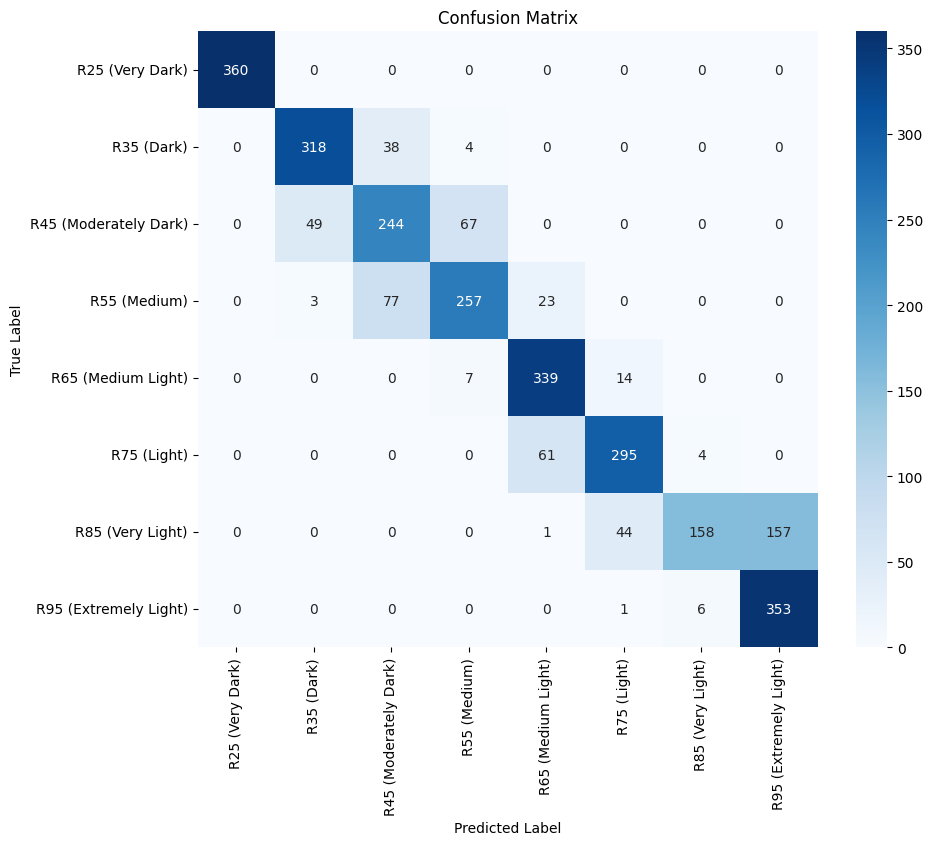

In [ ]:
sorted_labels = sorted(label_mapping.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes, labels=[label_mapping[label] for label in sorted_labels])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Evaluasi Test Set

#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


12/12 [==============================] - 2s 86ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       0.92      0.27      0.41        45
           R35 (Dark)       0.92      0.73      0.81        45
         R55 (Medium)       0.81      0.78      0.80        45
      R25 (Very Dark)       0.96      1.00      0.98        45
   R65 (Medium Light)       0.78      0.87      0.82        45
R45 (Moderately Dark)       0.67      0.78      0.72        45
R95 (Extremely Light)       0.65      0.98      0.78        45
          R75 (Light)       0.73      0.82      0.77        45

             accuracy                           0.78       360
            macro avg       0.80      0.78      0.76       360
         weighted avg       0.80      0.78      0.76       360

Accuracy: 0.7778
Precision: 0.8046
Recall: 0.7778
F1-Score: 0.7618


#### Confusion Matrix

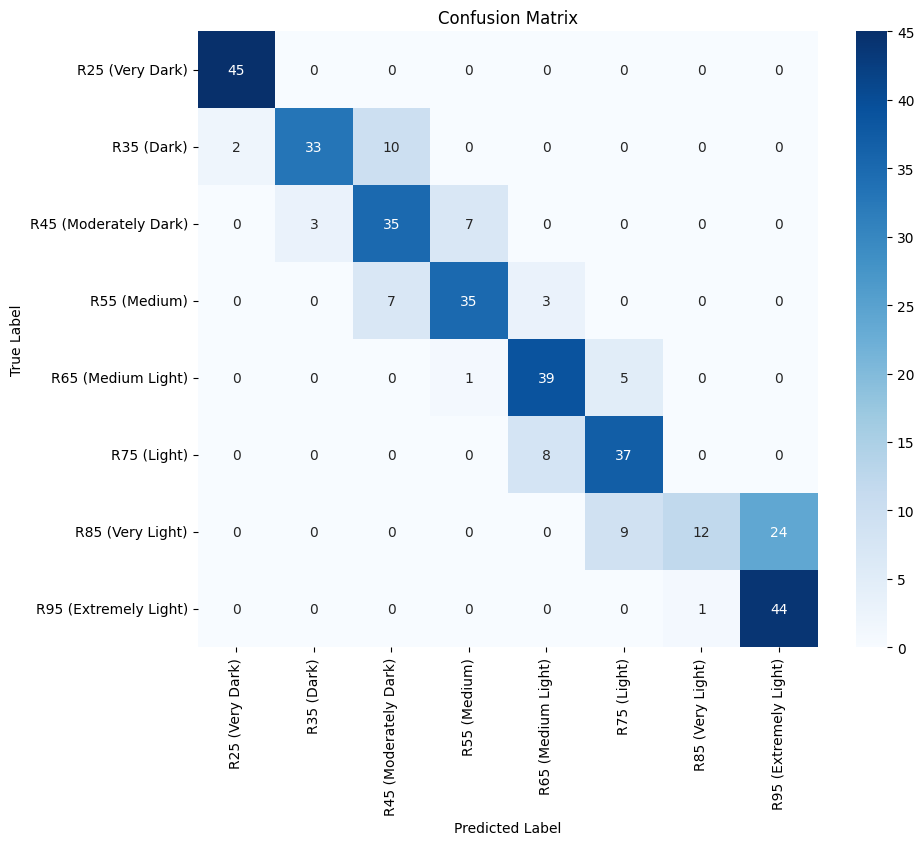

In [ ]:
sorted_labels = sorted(label_mapping.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes, labels=[label_mapping[label] for label in sorted_labels])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save history for comparison later
history_no_preprocessing_dict = {
    'accuracy': history_no_preprocessing.history['accuracy'],
    'val_accuracy': history_no_preprocessing.history['val_accuracy'],
    'loss': history_no_preprocessing.history['loss'],
    'val_loss': history_no_preprocessing.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


### Accuracy & Loss over Time

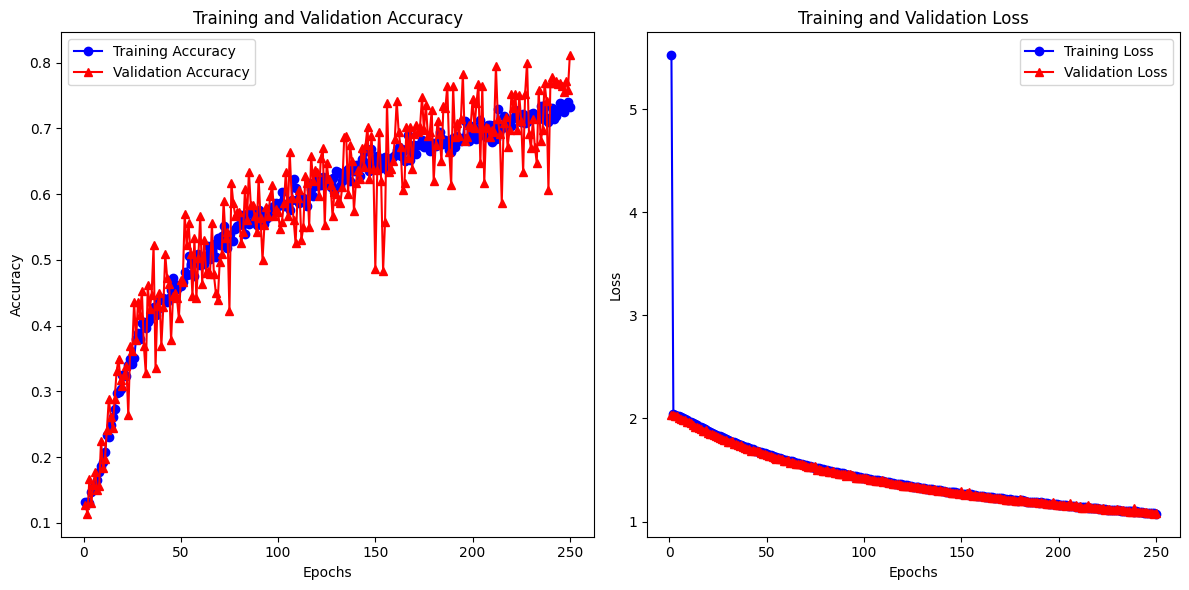

In [ ]:
# Extract values from history dictionary
accuracy = history_no_preprocessing_dict['accuracy']
val_accuracy = history_no_preprocessing_dict['val_accuracy']
loss = history_no_preprocessing_dict['loss']
val_loss = history_no_preprocessing_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()